In [ ]:
fs = 32e9  # 32 GHz sampling rate
fs_num = 32  # 32 GHz sampling rate in numerical form
up_fs = 1024e9  # 1024 GHz upsampled rate
up_fs_num = 1024  # 1024 GHz upsampled rate in numerical form

In [ ]:
"""
process_sensor_data.py

本脚本用于读取原始传感器数据（CSV文件），将其重采样到16 GHz的时间分辨率，并保存为新的CSV文件。
This script reads raw sensor data (CSV file), resamples it to a 16 GHz time resolution, and saves it as a new CSV file.

主要功能 / Main Features:
1. 读取原始数据文件（假设有时间和数据两列）。
   Reads the original data file (assumed to have two columns: time and data).
2. 数据清洗和类型转换。
   Cleans the data and converts types.
3. 时间轴归零。
   Resets the time axis to start from zero.
4. 以16 GHz采样率进行线性插值重采样。
   Performs linear interpolation resampling at 16 GHz sampling rate.

适用场景 / Application Scenarios:
信号处理、通信等需要高精度时间对齐的数据分析。
Signal processing, communications, and other data analysis requiring high-precision time alignment.
"""

import pandas as pd
import numpy as np

# Define input and output file names
input_filename = "../csv/8PPM_500Mbps.csv"
output_filename = f"../csv/ppm{fs_num}.csv"
# input_filename = "../csv/8DPSK_500Mbps_5u.csv"
# output_filename = f"../csv/dpsk{fs}.csv"

# Define the target resampling frequency and interval
target_frequency_hz = fs
resampling_interval_s = 1 / target_frequency_hz

try:
    # Read the CSV file, skipping the original header row to replace it later
    df = pd.read_csv(input_filename, header=0)

    # Rename columns for clarity based on the original header structure
    # Assuming the first column is time-like and second is data-like
    df.columns = ['original_time', 'original_data']

    # Convert columns to numeric, coercing errors if any
    df['original_time'] = pd.to_numeric(df['original_time'], errors='coerce')
    df['original_data'] = pd.to_numeric(df['original_data'], errors='coerce')

    # Drop rows with NaN values that might have resulted from coercion
    df.dropna(subset=['original_time', 'original_data'], inplace=True)

    if df.empty:
        print(f"Error: No valid numeric data found in {input_filename} after header processing.")
    else:
        # Adjust time axis to start from zero
        min_time = df['original_time'].min()
        df['time'] = df['original_time'] - min_time

        # Prepare for resampling
        # The new time axis will start from 0 (because df['time'] now starts from 0)
        # and go up to the maximum duration of the adjusted time
        start_resample_time = 0
        end_resample_time = df['time'].max()

        new_time_axis = np.arange(start_resample_time, end_resample_time, resampling_interval_s)

        # Perform linear interpolation
        # np.interp needs the original x-values (df['time']) to be sorted
        df_sorted = df.sort_values(by='time')
        resampled_data_values = np.interp(new_time_axis, df_sorted['time'], df_sorted['original_data'])

        # Create a new DataFrame for the resampled data
        df_resampled = pd.DataFrame({'time': new_time_axis, 'data': resampled_data_values})

        # Display the resampled data information without saving to file
        print(f"Processing complete. Data processed but not saved.")
        print(f"New header: time,data")
        print(f"Time axis starts from 0.")
        print(f"Data resampled to {target_frequency_hz / 1e9} GHz.")
        print(f"Resampled data shape: {df_resampled.shape}")
        print(f"First few rows of resampled data:")
        print(df_resampled.head())

except FileNotFoundError:
    print(f"Error: The file {input_filename} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")



,original_time,original_data,time
0,0.000015,-0.073289,0.000000e+00
1,0.000015,-0.074507,4.249693e-13
2,0.000015,-0.076148,1.001956e-12
3,0.000015,-0.077678,1.545910e-12
4,0.000015,-0.080711,2.633819e-12
...,...,...,...
3260114,0.000020,-0.056958,4.999994e-06
3260115,0.000020,-0.062241,4.999996e-06
3260116,0.000020,-0.067786,4.999998e-06
3260117,0.000020,-0.070584,4.999999e-06


In [13]:
# save csv
df_time0 = pd.DataFrame({'time': df["time"], 'data': df["original_data"]})
df_time0.to_csv("../csv/8PPM_500Mbps_t0.csv", index=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the square of the data to find power
df_resampled['Data_Squared'] = df_resampled['data'] ** 2

# Plot the squared data
plt.figure(figsize=(12, 6))
plt.plot(df_resampled['time'], df_resampled['Data_Squared'])
plt.xlabel('Time (s)')
plt.ylabel('Data Squared')
plt.title('Data Squared vs Time')
plt.grid(True)
plt.xlim(0, 1e-8)  # Show first 10 ns
plt.show()

# Define the period for folding (assuming 500 Mbps symbol rate -> 2 ns period)
period = 2e-9  # 2 ns

# Use the squared data for folding analysis
data_to_fold = df_resampled['Data_Squared'].dropna()
time_to_fold = df_resampled.loc[data_to_fold.index, 'time']

# Calculate the time modulo the period
folded_time = time_to_fold % period

# Determine the time resolution
time_resolution = time_to_fold.diff().mean()
if pd.isna(time_resolution):
    time_resolution = (df_resampled['time'].iloc[1] - df_resampled['time'].iloc[0]) if len(df_resampled['time']) > 1 else 1e-12

# Create bins for the 0-2ns range
num_bins = max(1, int(period / time_resolution))
bins = np.linspace(0, period, num_bins + 1)

# Create a dataframe for folding
fold_df = pd.DataFrame({'time': folded_time, 'data': data_to_fold})

# Digitize the folded time to assign each time point to a bin
fold_df['time_bin'] = pd.cut(fold_df['time'], bins=bins, labels=False, include_lowest=True)

# Group by the bins and sum the data
summed_data = fold_df.groupby('time_bin')['data'].sum()

# Create the time axis for the summed data (using the middle of each bin)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Reindex the summed data to match the bins, filling missing bins with 0
summed_data = summed_data.reindex(range(len(bin_centers)), fill_value=0)

# Normalize the summed data to be between 0 and 1
summed_data = (summed_data - summed_data.min()) / (summed_data.max() - summed_data.min())

# Plot the folded result
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, summed_data)
plt.xlabel('Time (s) within 2ns period')
plt.ylabel('Summed Data (Normalized)')
plt.title('Data folded and summed over a 2ns period')
plt.grid(True)
plt.show()


In [ ]:
# Find the midpoint of the interval where data is above a threshold
threshold = 0.2

# Find where data is greater than threshold
above_threshold = summed_data > threshold

if above_threshold.any():
    # Get the time values for these points
    time_above_threshold = bin_centers[above_threshold]

    # Calculate the circular mean of the time points to handle wrap-around
    # Convert time to angles (radians)
    angles = (time_above_threshold / period) * 2 * np.pi

    # Compute the mean of the sines and cosines of the angles
    mean_sin = np.mean(np.sin(angles))
    mean_cos = np.mean(np.cos(angles))

    # Calculate the mean angle from the mean sine and cosine
    mean_angle = np.arctan2(mean_sin, mean_cos)

    # Convert the mean angle back to time
    midpoint_time = (mean_angle / (2 * np.pi)) * period

    # Adjust the midpoint to be in the [0, period] range
    if midpoint_time < 0:
        midpoint_time += period

    print(f"The midpoint of the interval where data is > {threshold} is: {midpoint_time:.4e} s")
    print(f"Need to delay the signal by {period - midpoint_time:.4e} s to align with the end of period.")
    print(f"This corresponds to {int((period - midpoint_time) * fs)} samples at {fs_num} GHz sampling rate.")

    # Plot the result with midpoint visualization
    plt.figure(figsize=(12, 6))
    plt.plot(bin_centers, summed_data, label='Summed Data')
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    plt.axvline(x=midpoint_time, color='g', linestyle='-', label=f'Midpoint ({midpoint_time:.2e} s)')
    plt.xlabel('Time (s) within 2ns period')
    plt.ylabel('Summed Data (Normalized)')
    plt.title('Data folded and summed over a 2ns period with Midpoint')
    plt.grid(True)
    plt.legend()
    plt.show()

else:
    print(f"No data points found above the threshold of {threshold}.")


In [ ]:
# Remove the first (midpoint_time + 1e-9) seconds of data
# Calculate the time threshold
time_threshold = midpoint_time + 1e-9  # Add 1 ns to midpoint_time

# Find the index where time first exceeds the threshold
indices_to_remove = df_resampled['time'] < time_threshold
num_points_to_remove = indices_to_remove.sum()

print(f"Time threshold: {time_threshold:.4e} s")
print(f"Number of data points to remove: {num_points_to_remove}")

# Create the trimmed dataframe
df_trimmed = df_resampled[~indices_to_remove].copy()

# Reset the time axis to start from 0 again
df_trimmed['time'] = df_trimmed['time'] - df_trimmed['time'].min()

# Reset the index
df_trimmed.reset_index(drop=True, inplace=True)

print(f"Original data shape: {df_resampled.shape}")
print(f"Trimmed data shape: {df_trimmed.shape}")
print(f"Data points removed: {df_resampled.shape[0] - df_trimmed.shape[0]}")
print(f"First few rows of trimmed data:")
print(df_trimmed.head())

# Plot the trimmed data
plt.figure(figsize=(12, 6))
plt.plot(df_trimmed['time'], df_trimmed['data'])
plt.xlabel('Time (s)')
plt.ylabel('Data')
plt.title('Trimmed Data vs Time')
plt.grid(True)
plt.xlim(0, 3e-8)  # Show 0-30 ns
# Set x-axis ticks every 2 ns
plt.xticks(np.arange(0, 3e-8 + 2e-9, 2e-9))
plt.show()

# Also plot the squared data for comparison
df_trimmed['Data_Squared'] = df_trimmed['data'] ** 2
plt.figure(figsize=(12, 6))
plt.plot(df_trimmed['time'], df_trimmed['Data_Squared'])
plt.xlabel('Time (s)')
plt.ylabel('Data Squared')
plt.title('Trimmed Data Squared vs Time')
plt.grid(True)
plt.xlim(0, 3e-8)  # Show 0-30 ns
# Set x-axis ticks every 2 ns
plt.xticks(np.arange(0, 3e-8 + 2e-9, 2e-9))
plt.show()


In [ ]:
# Save the trimmed data to CSV file
output_csv_file = f"../csv/ppm{fs_num}.csv"
# Only save time and data columns (exclude Data_Squared)
df_to_save = df_trimmed[['time', 'data']].copy()
df_to_save.to_csv(output_csv_file, index=False)
print(f"Trimmed data saved to {output_csv_file}")
print(f"Saved data shape: {df_to_save.shape}")
print(f"Columns saved: {list(df_to_save.columns)}")

In [ ]:
import pandas as pd

# Load the trimmed data (16 GHz, aligned and trimmed)
df_loaded = pd.read_csv(f'../csv/ppm{fs_num}.csv')
print(f"Loaded data from '../csv/ppm{fs_num}.csv'")
print(df_loaded.head())

# Add AWGN noise to the loaded signal with SNR=16 dB and signal power 3e-3

snr_db = 16  # SNR in dB
signal_power = 3e-3  # Given signal power

# Convert SNR from dB to linear scale
snr_linear = 10 ** (snr_db / 10)

# Calculate noise power
noise_power = signal_power / snr_linear

# Generate AWGN noise
noise = np.random.normal(loc=0, scale=np.sqrt(noise_power), size=len(df_loaded))

# Add noise to the signal
df_loaded['data'] = df_loaded['data']  # + noise

print(f"Added AWGN noise: SNR={snr_db} dB (linear={snr_linear:.2f}), signal power={signal_power}, noise power={noise_power:.2e}")
print(df_loaded.head())

In [ ]:
# Method 1: FFT-based zero-padding upsampling from fs_num GHz to 2048 GHz
print(f"=== FFT Zero-Padding Upsampling: {fs_num} GHz → {up_fs_num} GHz ===")

# Use the loaded data from the CSV file
x_orig = df_loaded['data'].to_numpy(dtype=np.float64)
N = len(x_orig)
upsample_factor = int(up_fs_num / fs_num)
print(f"Original data length: {N}")
print(f"Original sampling rate: {fs_num} GHz")
print(f"Target sampling rate: {up_fs_num} GHz")
print(f"Upsampling factor: {upsample_factor}×")

# Step 1: FFT of original data
X = np.fft.fft(x_orig)

# Step 2: Create zero-padded frequency domain signal
N_new = N * upsample_factor
X_padded = np.zeros(N_new, dtype=complex)

# For even N: split the Nyquist frequency component
if N % 2 == 0:
    # Copy positive frequencies [0, N/2]
    X_padded[:N//2] = X[:N//2]
    # Copy negative frequencies [N/2+1, N-1] to the end
    X_padded[N_new-N//2+1:] = X[N//2+1:]
    # Split Nyquist frequency (if it exists)
    X_padded[N//2] = X[N//2] / 2
    X_padded[N_new-N//2] = X[N//2] / 2
else:
    # For odd N: simpler case
    X_padded[:(N+1)//2] = X[:(N+1)//2]
    X_padded[N_new-(N-1)//2:] = X[(N+1)//2:]

# Step 3: IFFT to get upsampled signal
x_upsampled = np.fft.ifft(X_padded).real * upsample_factor  # Scale by upsampling factor

# Step 4: Create precise time axis
Ts_orig = 1 / fs  # Original sampling period
Ts_upsampled = Ts_orig / upsample_factor  # New sampling period
t_upsampled = np.arange(len(x_upsampled), dtype=np.float64) * Ts_upsampled

print(f"Upsampled data length: {len(x_upsampled)}")
print(f"New sampling period: {Ts_upsampled:.2e} s")
print(f"New sampling rate: {1/Ts_upsampled/1e9:.1f} GHz")

# Create DataFrame for the upsampled data
df_upsampled = pd.DataFrame({
    'time': t_upsampled,
    'data': x_upsampled
})

print(f"Upsampled data shape: {df_upsampled.shape}")
print(f"First few rows of {up_fs_num} GHz data:")
print(df_upsampled.head())

# Verify the upsampling quality by checking the time axis
print(f"\nTime axis verification:")
print(f"Original max time: {df_loaded['time'].max():.2e} s")
print(f"Upsampled max time: {t_upsampled.max():.2e} s")
print(f"Time axis ratio: {t_upsampled.max() / df_loaded['time'].max():.6f} (should be close to 1.0)")


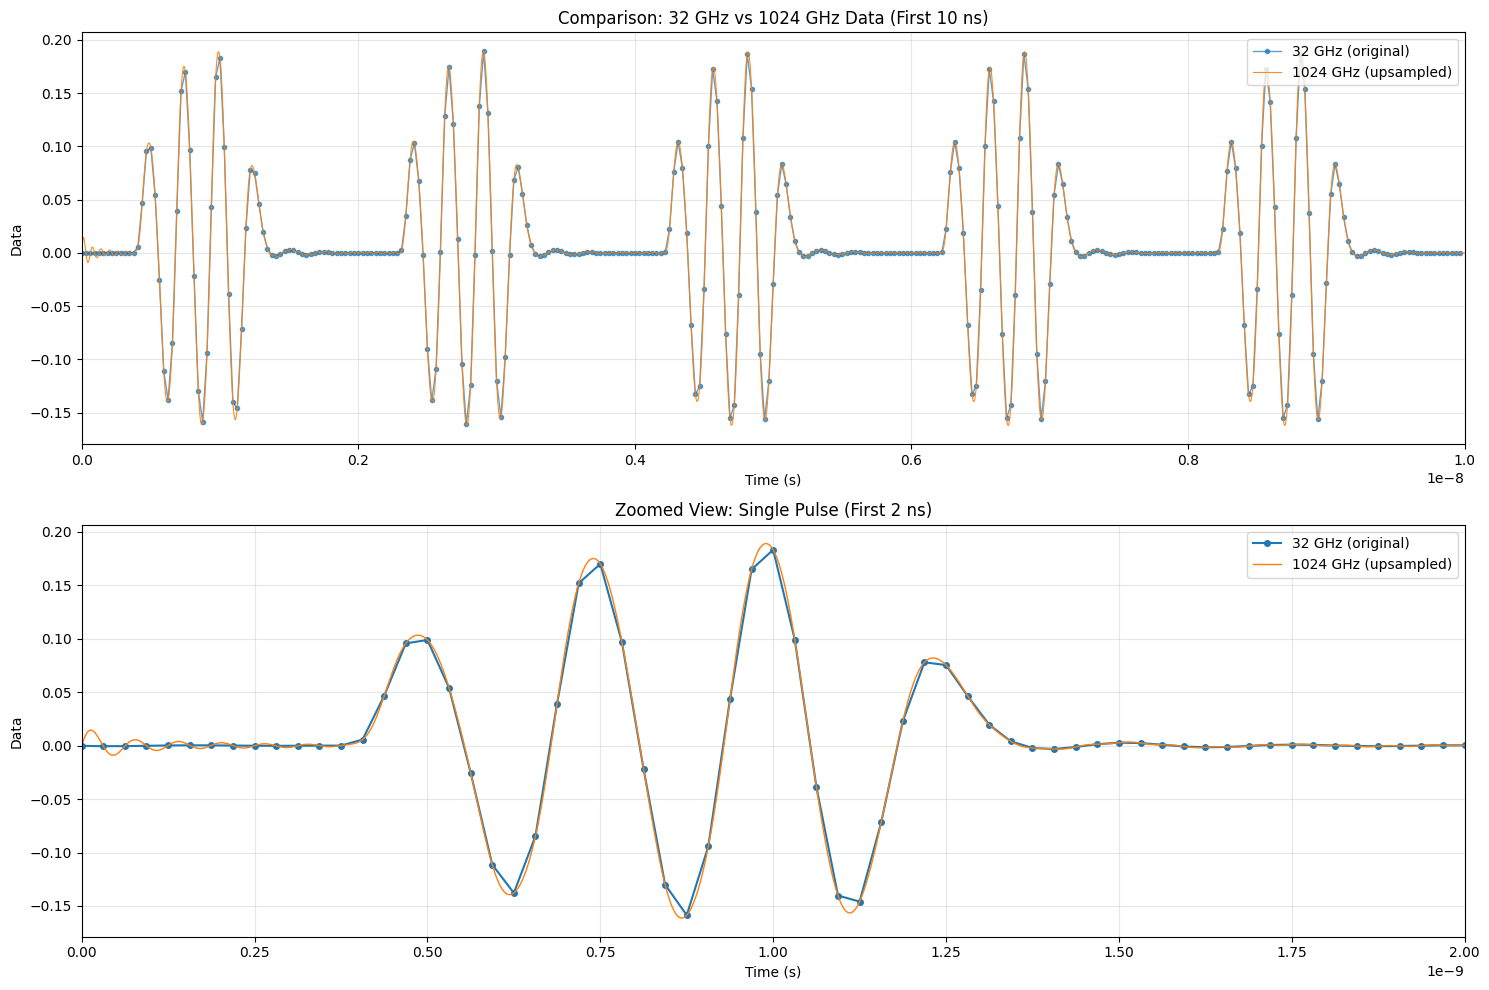


1024 GHz upsampled data saved to: ../csv/ppm1024.csv
File size: ~78.1 MB

Upsampling quality check:
Original data points: 159961
Upsampled data points: 5118752 (should be 5118752)
Ratio: 32.0 (should be 32.0)
Maximum difference at original sample points: 3.05e-16 (should be ~0)


In [10]:
# Plot comparison between original and upsampled data
plt.figure(figsize=(15, 10))

# Plot 1: First 1e-8 seconds comparison
plt.subplot(2, 1, 1)
time_limit = 1e-8

# fs_num GHz data
mask_orig = df_loaded['time'] <= time_limit
plt.plot(df_loaded.loc[mask_orig, 'time'], df_loaded.loc[mask_orig, 'data'], 
         'o-', markersize=3, linewidth=1, label=f'{fs_num} GHz (original)', alpha=0.7)

# up_fs_num GHz data
mask_upsampled = df_upsampled['time'] <= time_limit
plt.plot(df_upsampled.loc[mask_upsampled, 'time'], df_upsampled.loc[mask_upsampled, 'data'], 
         '-', linewidth=0.8, label=f'{up_fs_num} GHz (upsampled)', alpha=0.9)

plt.xlabel('Time (s)')
plt.ylabel('Data')
plt.title(f'Comparison: {fs_num} GHz vs {up_fs_num} GHz Data (First 10 ns)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, time_limit)
plt.xticks(np.arange(0, time_limit + 2e-9, 2e-9))

# Plot 2: Zoomed view of one pulse
plt.subplot(2, 1, 2)
time_start = 0
time_end = 2e-9  # First 2 ns only

mask_orig_zoom = (df_loaded['time'] >= time_start) & (df_loaded['time'] <= time_end)
mask_upsampled_zoom = (df_upsampled['time'] >= time_start) & (df_upsampled['time'] <= time_end)

plt.plot(df_loaded.loc[mask_orig_zoom, 'time'], df_loaded.loc[mask_orig_zoom, 'data'], 
         'o-', markersize=4, linewidth=1.5, label=f'{fs_num} GHz (original)')

plt.plot(df_upsampled.loc[mask_upsampled_zoom, 'time'], df_upsampled.loc[mask_upsampled_zoom, 'data'], 
         '-', linewidth=1, label=f'{up_fs_num} GHz (upsampled)')

plt.xlabel('Time (s)')
plt.ylabel('Data')
plt.title('Zoomed View: Single Pulse (First 2 ns)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(time_start, time_end)

plt.tight_layout()
plt.show()

# Save the up_fs_num GHz data to CSV
output_upsampled_file = f"../csv/ppm{up_fs_num}.csv"
df_upsampled.to_csv(output_upsampled_file, index=False)
print(f"\n{up_fs_num} GHz upsampled data saved to: {output_upsampled_file}")
print(f"File size: ~{len(df_upsampled) * 2 * 8 / 1024**2:.1f} MB")

# Calculate some quality metrics
print(f"\nUpsampling quality check:")
print(f"Original data points: {len(df_loaded)}")
print(f"Upsampled data points: {len(df_upsampled)} (should be {len(df_loaded) * upsample_factor})")
print(f"Ratio: {len(df_upsampled) / len(df_loaded):.1f} (should be {upsample_factor:.1f})")

# Check if the upsampled data preserves the original samples
original_indices = np.arange(0, len(df_upsampled), upsample_factor)
if len(original_indices) <= len(df_loaded):
    max_diff = np.max(np.abs(df_upsampled.iloc[original_indices]['data'].values[:len(df_loaded)] - df_loaded['data'].values))
    print(f"Maximum difference at original sample points: {max_diff:.2e} (should be ~0)")


In [ ]:
df_2048.describe()